In [1]:
library(magrittr)
library(tidyverse)
library(scales)
source("../wisdom/code/r/clean_theme.R")
source("../data/env/variables.R")

options("readr.num_columns" = 0)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable == 1)
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Origin=="Tumor")

# read mutation information
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,GeneId,Symbol,Patient) %>%
    unique

# read cna information
cna_drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/CNA_drivers_per_tumor_type.tsv", skip = 9) %>%
    rename(Symbol = geneHGNCsymbol,
           Tumor = Tumor_type_GISTIC,
           What = GISTIC_CNA) %>%
    select(Symbol, Tumor, What) %>%
    mutate(Tumor = ifelse(Tumor=="COREAD", "coad", Tumor),
           Tumor = ifelse(Tumor=="HC", "lihc", Tumor),
           Tumor = ifelse(Tumor=="RCCC", "kirc", Tumor),
           Tumor = tolower(Tumor) )

cna <- lapply(cancerTypes, function(tumor){
    paste0("../data/cnv/", tumor, "_gene_cnv-count_full.txt") %>%
        read_tsv(col_names = FALSE, col_types = "ciicicciicdc") %>%
        set_colnames(c("chr_gene","start_gene","end_gene","Gene","wut1","strand",
                       "chr","start","end","Patient","score","wut2")) %>%
        filter(score > log2(3/2) | score < log2(1/2)) %>%
        mutate(What = ifelse(score < log2(1/2), "D", "A")) %>%
        select(Gene, Patient, What) %>%
        unique %>%
        separate(Gene, into = c("Symbol", "GeneId"), sep = "\\|") %>%
        mutate(Tumor = tumor)
        
}) %>% do.call("rbind",.)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric



In [2]:
potus <- switches %>%
    filter(Candidate==1) %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

# check that all the patients have at least one switch/mutation
switchesPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    plyr::count(patients) %>%
        set_colnames(c("Patient","Switches")) %>%
        mutate(Tumor = tumor)
}) %>% do.call("rbind",.)
                             
mutationsPerPatient <- lapply(cancerTypes, function(tumor){
    
    # read mutations  
    ## get cancer specific drivers
    tumor.drivers <- drivers$Symbol[drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    mutations.drivers <- wes %>%
        filter(Tumor == tumor) %>%
        filter(Symbol %in% tumor.drivers) %>%
        ## consider only mutated genes, not several mutations in a gene
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    plyr::count(mutations.drivers$Patient) %>%
        set_colnames(c("Patient","Mutations")) %>%
        mutate(Tumor = tumor)
}) %>% do.call("rbind",.)

cnaPerPatient <- lapply(cancerTypes, function(tumor){
                              
    # read cna  
    ## get cancer specific drivers
    tumor.cna_drivers <- cna_drivers$Symbol[cna_drivers$Tumor==tumor]
   
    ## filter out cna not in drivers
    cna.cna_drivers <- cna  %>%
        filter(Symbol %in% tumor.cna_drivers) %>%
        select(GeneId,Patient) %>%
        unique
    
    ## count number of cna per patient
    cnaPerPatient <- plyr::count(cna.cna_drivers$Patient) %>%
        set_colnames(c("Patient","CNA")) %>%
        mutate(Tumor = tumor)
}) %>% do.call("rbind",.) %>% 
    # remove tumors with no-known cnv drivers
    filter(Tumor %in% cna_drivers$Tumor)
                        
patients.swt <- switches$Patients_affected %>% strsplit(",") %>% unlist %>% unique
patients.mut <- wes$Patient %>% unique
patients.cna <- cna$Patient %>% unique

patients.mut.cna <- intersect(patients.mut,patients.cna)
patients.swt.cna <- intersect(patients.swt,patients.cna)

Loading required package: RColorBrewer


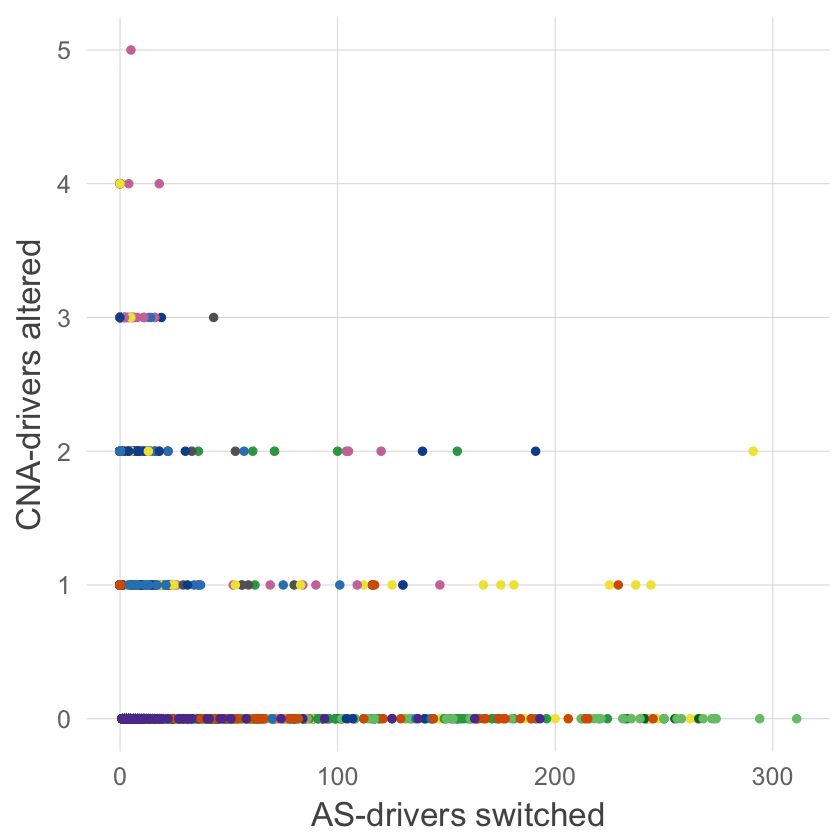

In [3]:
merge(cnaPerPatient,switchesPerPatient, all=T) %>%
    mutate(Switches = ifelse(is.na(Switches), 0, Switches ),
           CNA = ifelse(is.na(CNA), 0, CNA)) %>%
    filter(Patient %in% patients.swt.cna) %>% 
    ggplot(aes(x=Switches,y=CNA,color=Tumor)) + 
        geom_point(size=2) + 
        labs(x="AS-drivers switched",y="CNA-drivers altered") +
        scale_color_manual(values=colorPalette) +
        clean_theme()

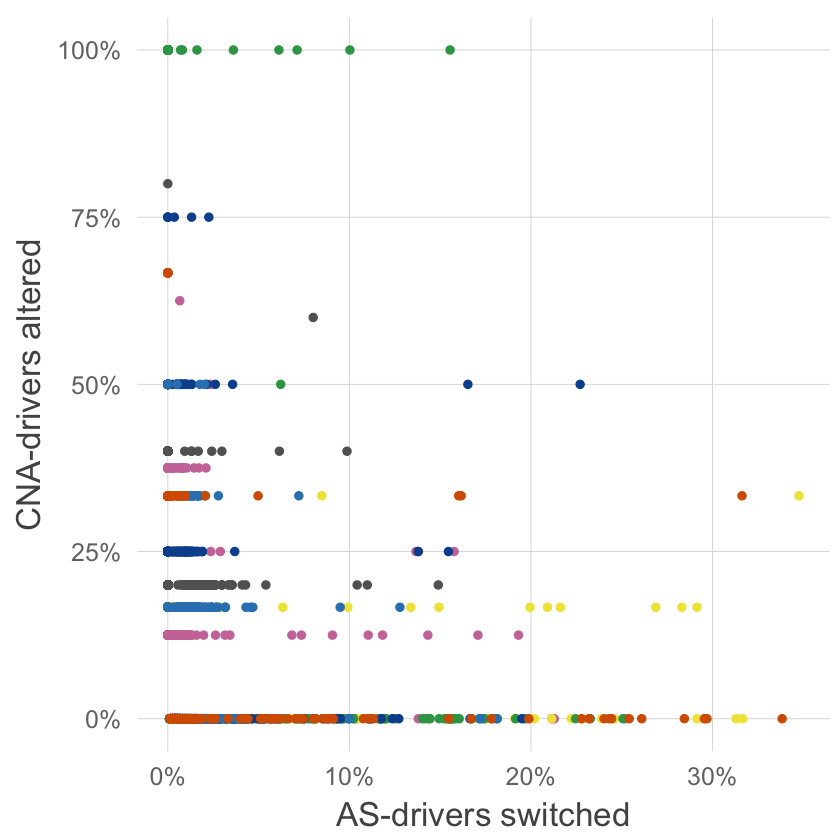

In [4]:
numCna_drivers <- cna_drivers %>%
    group_by(Tumor) %>%
    summarise(CNAtotal = n())

numPotus <- switches.split %>%
        merge(potus) %>%
        group_by(Tumor) %>%
        summarise(PotusTotal = n())

merge(cnaPerPatient,switchesPerPatient, all=T) %>%
    mutate(Switches = ifelse(is.na(Switches), 0, Switches ),
           CNA = ifelse(is.na(CNA), 0, CNA)) %>%
    filter(Patient %in% patients.swt.cna) %>% 
    merge(numCna_drivers) %>%
    merge(numPotus) %>%
    mutate(CNA = CNA/CNAtotal,
           Switches = Switches/PotusTotal) %>%
    ggplot(aes(x=Switches,y=CNA,color=Tumor)) + 
        geom_point(size=2) + 
        labs(x="AS-drivers switched",y="CNA-drivers altered") +
        scale_color_manual(values=colorPalette) +
        clean_theme() +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)

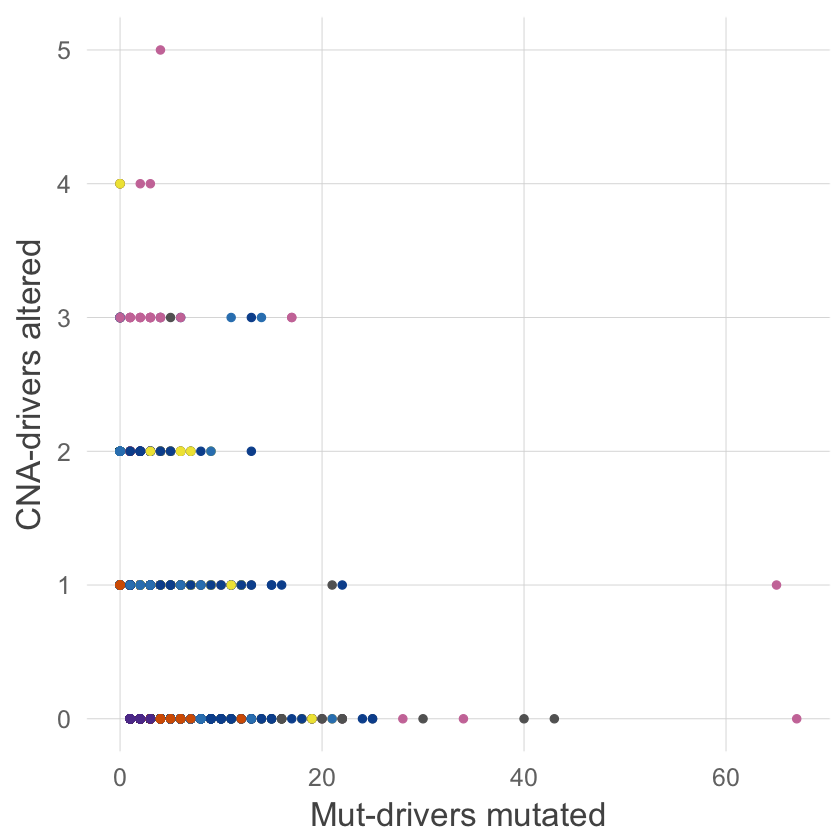

In [5]:
merge(cnaPerPatient,mutationsPerPatient, all=T) %>%
    mutate(Mutations = ifelse(is.na(Mutations), 0, Mutations ),
           CNA = ifelse(is.na(CNA), 0, CNA)) %>%
    filter(Patient %in% patients.mut.cna) %>% 
    ggplot(aes(x = Mutations, y = CNA, color = Tumor)) + 
        geom_point(size = 2) + 
        labs(x = "Mut-drivers mutated", y = "CNA-drivers altered") +
        scale_color_manual(values = colorPalette) +
        clean_theme()

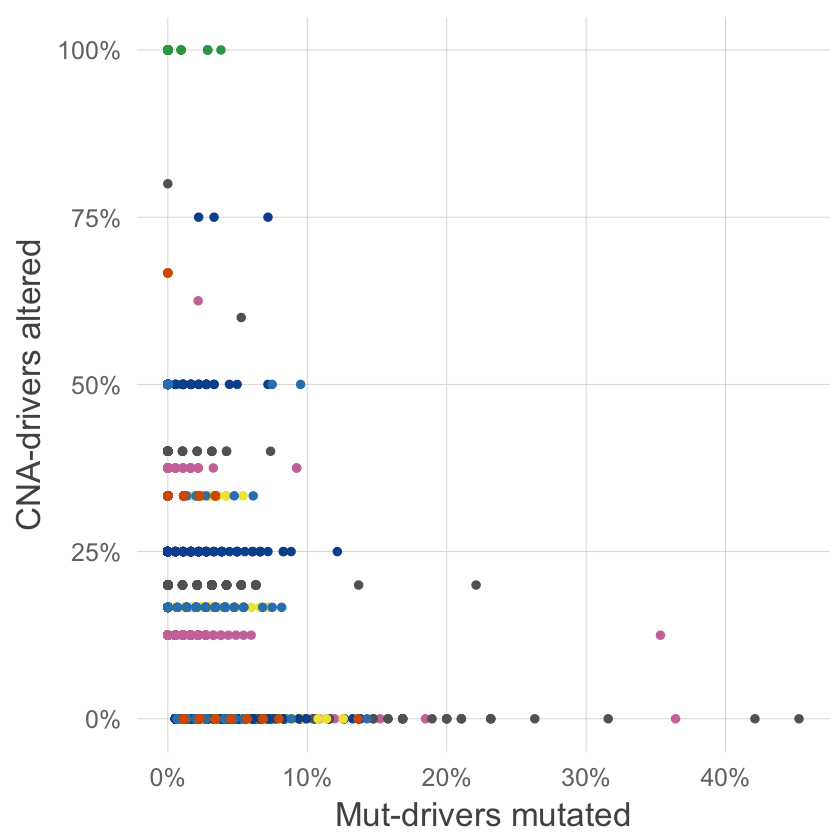

In [6]:
numMut_drivers <- drivers %>%
    group_by(Tumor) %>%
    summarise(MutTotal = n())

merge(cnaPerPatient,mutationsPerPatient, all=T) %>%
    mutate(Mutations = ifelse(is.na(Mutations), 0, Mutations ),
           CNA = ifelse(is.na(CNA), 0, CNA)) %>%
    filter(Patient %in% patients.mut.cna) %>%
    merge(numCna_drivers) %>%
    merge(numMut_drivers) %>%
    mutate(CNA = CNA/CNAtotal,
           Mutations = Mutations/MutTotal) %>%
    ggplot(aes(x = Mutations, y = CNA, color = Tumor)) + 
        geom_point(size = 2) + 
        labs(x = "Mut-drivers mutated", y = "CNA-drivers altered") +
        scale_color_manual(values = colorPalette) +
        clean_theme() +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)